In [9]:
from Define_Model.FilterLayer import FreqTimeReweightLayer, get_weight
import torch
import kaldiio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

import pandas as pd
import json
import os
import h5py
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from python_speech_features import hz2mel, mel2hz

%matplotlib inline

In [11]:
root_dir = '/home/yangwenhao/project/SpeakerVerification-pytorch'

In [7]:
ftl = FreqTimeReweightLayer()
# x = torch.randn(2, 1, 300, 161)
sample = kaldiio.load_mat('/home/yangwenhao/local/project/lstm_speaker_verification/data/vox2/klsp/spect/dev/raw_spect_dev.1.ark:26')
chunk_sample = sample[300:]
x = torch.tensor(chunk_sample).unsqueeze(0).unsqueeze(0)
x -= x.mean(dim=-2, keepdim=True)

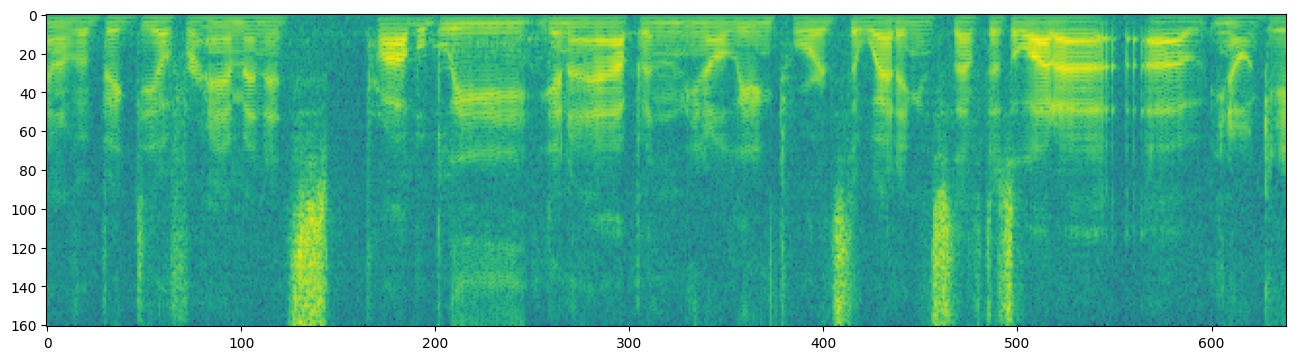

In [8]:
plt.figure(figsize=(16, 6))

plt.imshow(chunk_sample.T)

In [9]:
weight = torch.ones(1,1,1,161)
sig = torch.nn.Sigmoid()

In [10]:
y1 = x * sig(weight)
y2 = x * sig(y1.sum(dim=-2, keepdim=True))

In [ ]:
sig(y1.sum(dim=-2, keepdim=True))

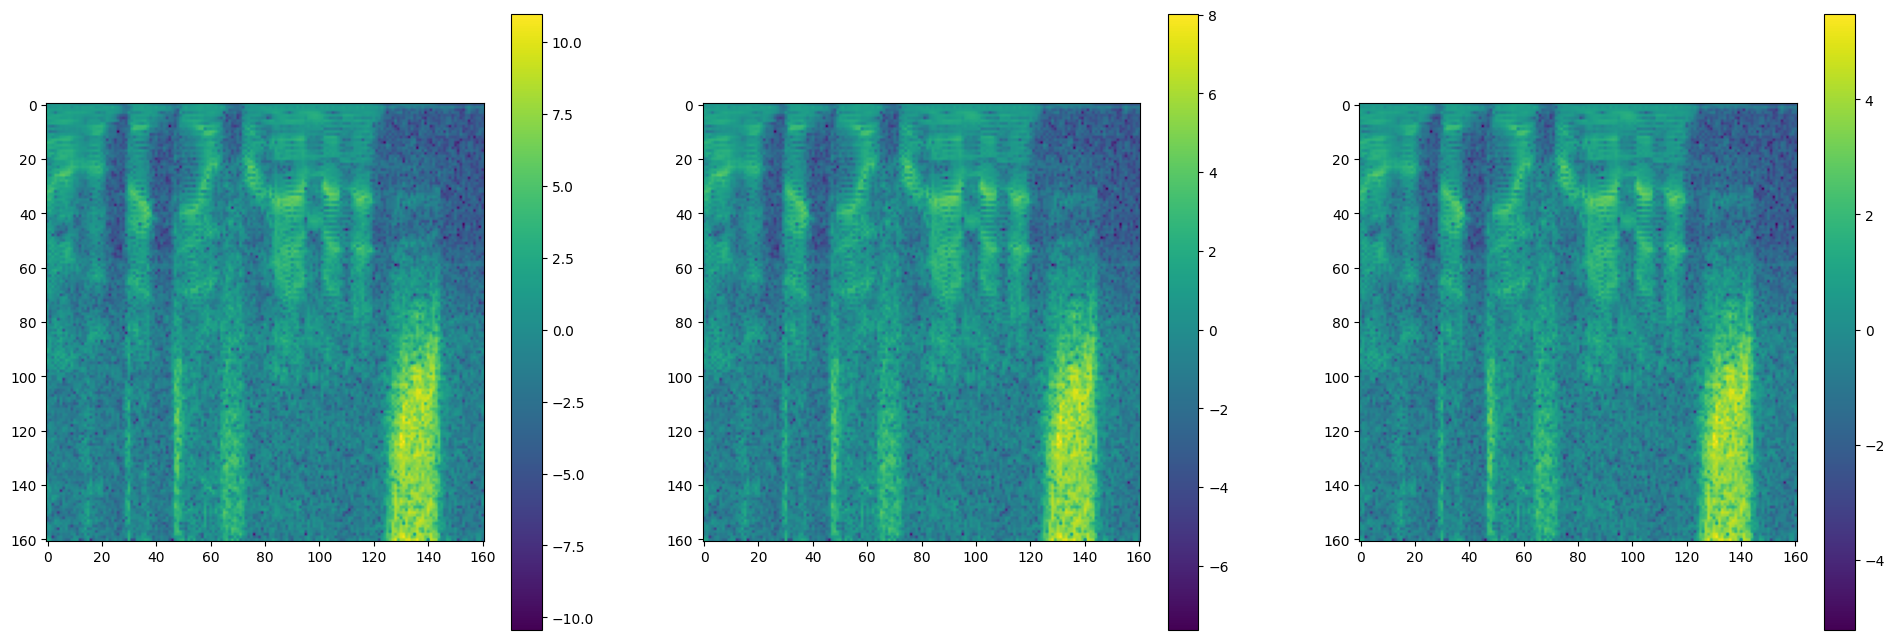

In [12]:
y = ftl(x)

plt.figure(figsize=(24, 8))
plt.subplot(1,3,1)
plt.imshow(x.squeeze().detach().numpy().T[:,:161])
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(y1.squeeze().detach().numpy().T[:,:161])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(y2.squeeze().detach().numpy().T[:,:161])
plt.colorbar()

In [ ]:
y = ftl(x)

plt.figure(figsize=(18, 8))
plt.subplot(1,3,1)
plt.imshow(x.squeeze().detach().numpy().T[:,:161])
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(y.squeeze().detach().numpy().T[:,:161])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow((x-y).squeeze().detach().numpy().T[:,:161])
plt.colorbar()

In [5]:
mel = get_weight(weight='mel', input_dim=161, power_weight='')

In [6]:
ftl.weight.data *= torch.tensor((mel-mel.mean())*10).reshape(1,1,1,-1)

In [41]:
ftl.weight.data

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1.]]]])

In [26]:
mel.shape

(161,)

In [63]:
a = x.squeeze().numpy()[:200,:]
final = np.zeros(a.shape)
threshold = 0.15

In [59]:
print(a.shape, final.shape)

(200, 161) torch.Size([200, 161])


In [52]:
a.reshape(1, 200*161)

array([[ 0.90426636,  0.9099083 ,  1.7623205 , ..., -1.743185  ,
        -2.9328976 , -2.4849186 ]], dtype=float32)

In [66]:
start = a.reshape(1, 200*161, order='F')
final = final.reshape(1, 200*161, order='F')

In [65]:
start.shape

(1, 32200)

In [67]:
start[0, 0:int((200*161)*threshold)] = final[0, 0:int((200*161)*threshold)]

In [68]:
start = torch.from_numpy(start.reshape(200, 161, order='F'))

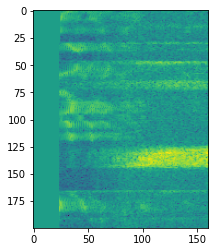

In [69]:
plt.imshow(start)

In [116]:
time_data = []
p = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/data_grad.pickle'
with open(p, 'rb') as f:
    for (data, grad) in pickle.load(f):
        time_data.append((data, grad))
        break

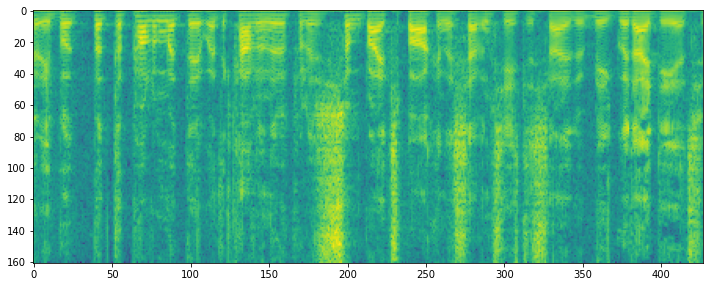

In [117]:
plt.figure(figsize=(12, 6))
plt.imshow(time_data[0][0].T)

In [118]:
def preprocessing(grad, dim=80):
    grad_t = grad.sum(axis=1, keepdims=True)#.reshape(-1,1)
    cam_min, cam_max = grad_t.min(), grad_t.max()

    pre_cam = np.tile((grad_t - cam_min) / (cam_max - cam_min + 1e-8), (1, dim))
    # pre_cam = np.int64(pre_cam > 0.4).reshape(-1, dim)

    return pre_cam

In [119]:
x = time_data[0][0][:200]
c = time_data[0][1][:200]

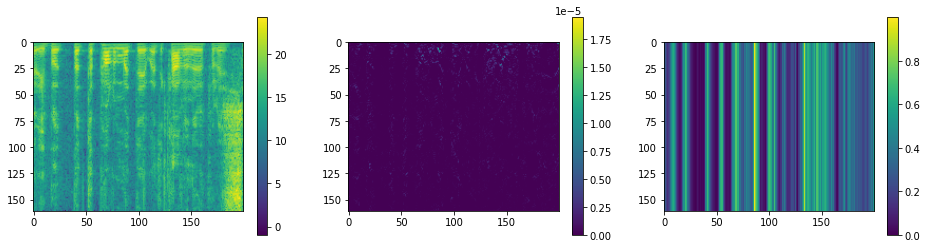

In [124]:
plt.figure(figsize=(16, 4))

plt.subplot(1,3,1)
plt.imshow(x.T)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(c.T)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(preprocessing(c, dim=161).T)
plt.colorbar()

In [145]:
def input_reprocessing(data, grad, threshold=0.15, pro_type='del'):
    H, W = data.shape
    start = np.zeros(data.shape)
    final = data.copy()

    if pro_type == 'insertion':
        salient_order = np.flip(np.argsort(grad.reshape(H*W)), axis=0)
    else:
        salient_order = np.argsort(grad.reshape(H*W))
        threshold = 1 - threshold
    
    coords = salient_order[0:int((H*W)*threshold)]
    start.reshape(H*W)[coords] = final.reshape(H*W)[coords]

    return start

In [130]:
salient_order = np.flip(np.argsort(c.reshape(-1), axis=0))
coords = salient_order[0:int((200*161)*threshold)]

In [131]:
coords

array([13692, 13855, 21421, ..., 17803, 17132, 28886])

In [139]:
threshold = 0.85

salient_order = np.flip(np.argsort(c.reshape(-1), axis=0))
coords = salient_order[0:int((200*161)*threshold)]

final = x.copy()
start = np.zeros(x.shape)

start.reshape(200*161)[coords] = final.reshape(200*161)[coords]

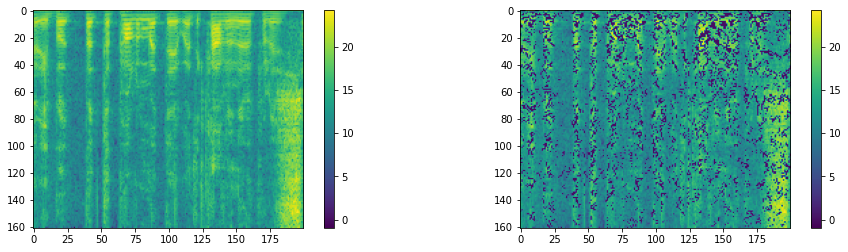

In [151]:
plt.figure(figsize=(16, 4))

plt.subplot(1,2,1)
plt.imshow(x.T)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(input_reprocessing(x, c, threshold=0.15,).T)
plt.colorbar()

In [136]:
np.argsort(np.arange(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [251]:
label_pred = []

for i in range(10):
    l = np.random.randn(1)
    p = torch.randn(5994).numpy()
    label_pred.append([l, p])

In [252]:
label_pred[0][0]

array([0.63563021])

In [253]:
df = pd.DataFrame(label_pred, columns=['label', 'predict'])

In [258]:
json(torch.randn(1)[0].numpy())

TypeError: 'module' object is not callable

In [4]:
def pick2h5py(eval_dir, utt2spk):
    uid_json = os.path.join(eval_dir, 'data_grad.uid.json')
    with open(uid_json, 'r') as f:
        uids = json.load(f)
    if len(uids) != len(set(uids)):
        print(len(uids), len(set(uids)))
    
    sids = set([])
    uids_set = set(uids)
    uid2sid = {}
    with open(utt2spk, 'r') as f:
        for l in tqdm(f.readlines(), ncols=50):
            u, s = l.split()
            if u in uids_set:
                uid2sid[u] = s
                
            sids.add(s)
            
    sids = list(sids)
    sids.sort()
    
    sid2idx = {i: idx for idx, i in enumerate(sids)}
        
    p = os.path.join(eval_dir, 'data_grad.pickle')
    data_file = os.path.join(eval_dir, 'data.h5py')
    grad_file = os.path.join(eval_dir, 'grad.h5py')
    saved_uid = set([])
    
    with open(p, 'rb') as f:
        with h5py.File(data_file, 'w') as df, \
            h5py.File(grad_file, 'w') as gf:
            for i, (d, g) in tqdm(enumerate(pickle.load(f)), ncols=50):
                if uids[i] not in saved_uid:
                    saved_uid.add(uids[i])
                    df.create_dataset(uids[i], data=d)
                    gf.create_dataset(uids[i], data=g)
                
    uid2idx_file = os.path.join(eval_dir, 'uid_idx.json')
    uid2idx = [[u, sid2idx[uid2sid[u]]] for u in uids]
    with open(uid2idx_file, 'w')as f:
        json.dump(uid2idx, f)


In [183]:
eval_dir = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41'
utt2spk = '/home/yangwenhao/local/project/lstm_speaker_verification/data/vox2/dev/utt2spk'

pick2h5py(eval_dir, utt2spk)

23976 23395


100%|█| 1092009/1092009 [00:00<00:00, 2314885.07it
23976it [06:16, 63.76it/s] 


In [3]:
mask_accs = {}

for mask_type in ['insert', 'del']:
    mask_accs[mask_type] = []
    
    for threshold in [0.1,0.2,0.4,0.8,0.9]:
        all_labels = pd.read_json('../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/vox2_valid.label_pred.{}.{:.2f}.json'.format(mask_type, threshold))
        labels = np.array(all_labels.label.to_list()).reshape(-1)
        predicted_labels = np.array(all_labels.predict.to_list())
        accuracy = np.sum(labels == np.argmax(predicted_labels, axis=1)) / len(labels) * 100
        
        mask_accs[mask_type].append([threshold, accuracy])

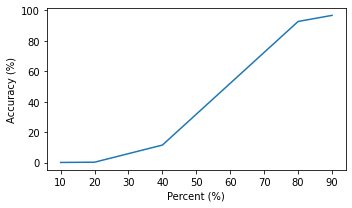

In [52]:
legs = ['insert', 'del']
pdf = PdfPages('gfa/insert.pdf')

plt.figure(figsize=(5, 4))
m = legs[0]
# for i,m in enumerate(legs):
# plt.subplot(1,2,int(i+1))
result = mask_accs[m]
xy = np.array(result)
x_idx = np.argsort(xy[:, 0])
xy = xy[x_idx]
plt.plot(xy[:,0]*100, xy[:,1])
# plt.title(m)
plt.ylabel('Accuracy (%)')
plt.xlabel('Percent (%)')
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

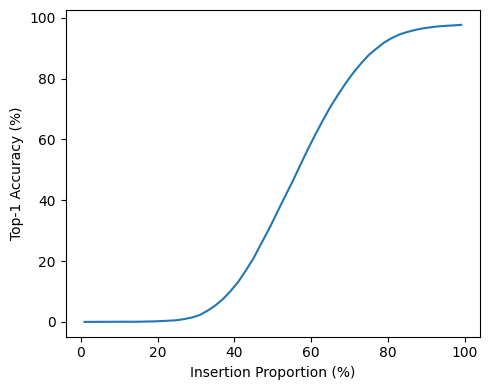

In [15]:
legs = ['insert', 'del']
pdf = PdfPages('gfa/insert.pdf')

plt.figure(figsize=(5, 4))

with open('../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/result.json', 'r') as f:
    result = json.load(f)

xy = []
for mask_type, threshold, acc in result:
    if mask_type == 'insert':
        xy.append([threshold, acc])

xy = np.array(xy)
x_idx = np.argsort(xy[:, 0])
xy = xy[x_idx]

plt.plot(xy[:,0]*100, xy[:,1])
# plt.title(m)
plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Insertion Proportion (%)')
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

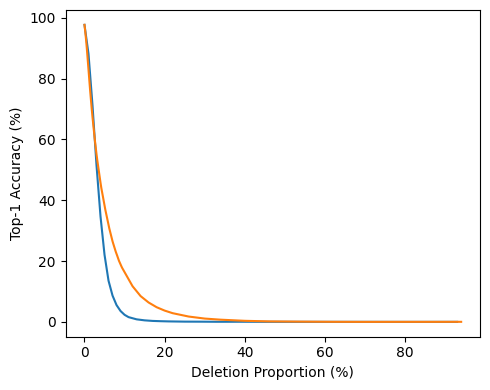

In [13]:
legs = ['insert', 'del']
pdf = PdfPages('gfa/delete.pdf')

plt.figure(figsize=(5, 4))

with open('../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/result.json', 'r') as f:
    result = json.load(f)

xy = []
for mask_type, threshold, acc in result:
    if mask_type == 'del':
        xy.append([threshold, acc])

xy = np.array(xy)
x_idx = np.argsort(xy[:, 0])
xy = xy[x_idx]

plt.plot(xy[:,0]*100, xy[:,1])


with open('../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/result.mean.json', 'r') as f:
    result = json.load(f)
xy = []
for mask_type, threshold, acc in result:
    if mask_type == 'del':
        xy.append([threshold, acc])

xy = np.array(xy)
x_idx = np.argsort(xy[:, 0])
xy = xy[x_idx]

plt.plot(xy[:,0]*100, xy[:,1])
# plt.title(m)
plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Deletion Proportion (%)')
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

In [65]:
1/161

0.006211180124223602

In [4]:
from Misc.analysis import format_eer_file, read_eer_file, format_eer_file_train, format_eer_file_eval

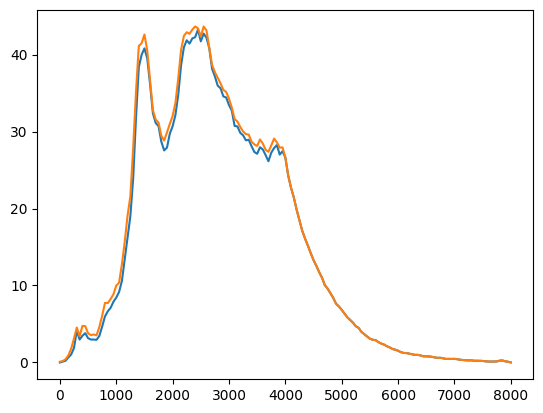

In [6]:
with open('../../Data/gradient/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/epoch_15_var/layer_cam_soft/result.mean.mask.json', 'r') as f:
    mask_result = json.load(f)
    
x = np.arange(161) * 8000 / (161 - 1)
y = []
y2 = []
for s, e, acc in mask_result:
    if e-s == 1:
        y.append(acc)
    else:
        y2.append(acc)
y = np.array(y)
plt.plot(x, y[-1]-y[:len(x)])

y2 = np.array(y2)
plt.plot(x, y2[-1]-y2[:len(x)])

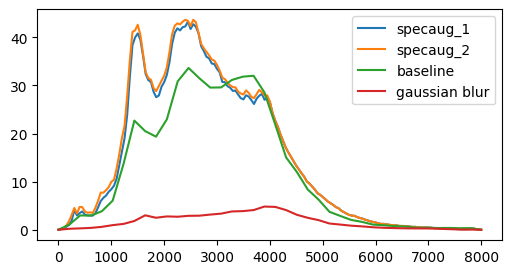

In [14]:
with open('../../Data/gradient/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/epoch_15_var/layer_cam_soft/result.mean.mask.json', 'r') as f:
    mask_result = json.load(f)
    
x = np.arange(161) * 8000 / (161 - 1)
y = []
y2 = []
y3 = []
y4 = []
for l in mask_result:
    if len(l)==3:
        s, e, acc = l
        ty = ''
    else:
        s, e, acc, ty = l
        
    if ty == 'const':
        y3.append(acc)
    elif ty == 'blur':
        y4.append(acc)
    elif e-s == 1:
        y.append(acc)
    else:
        y2.append(acc)
        
plt.figure(figsize=(6, 3))
    
y = np.array(y)
the_y = y.max()-y[:len(x)]
# the_y /= the_y.max()
plt.plot(x, the_y)

y2 = np.array(y2)
the_y = y2.max()-y2[:len(x)]
# the_y /= the_y.max()
plt.plot(x, the_y)

y3 = np.array(y3)
x3 = np.arange(len(y3)) * 8000 / (len(y3) - 1)
the_y = y3.max()-y3[:len(x3)]
# the_y /= the_y.max()
plt.plot(x3, the_y)

y4 = np.array(y4)
x4 = np.arange(len(y4)) * 8000 / (len(y4) - 1)
the_y = y4.max()-y4[:len(x4)]
# the_y /= the_y.max()
plt.plot(x4, the_y)

plt.legend(['specaug_1', 'specaug_2', 'baseline', 'gaussian blur'])

In [13]:
os.path.exists('/home/yangwenhao/project/SpeakerVerification-pytorch/Data/gradient/ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_chn32_wd5e5_varesmix8/arcsoft_sgd_rop/vox2/wave_fb80_dist/123456/epoch_19_var/gradient_soft/result.mean.mask.json')

False

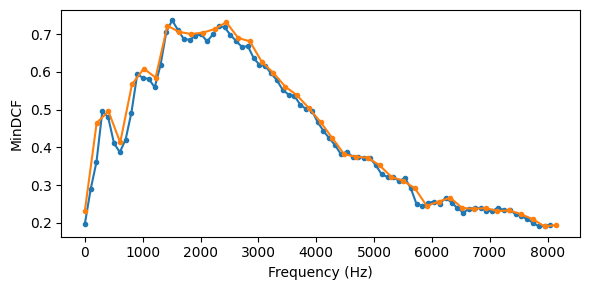

In [7]:
legs = ['insert', 'del']
pdf = PdfPages('gfa/pertub.pdf')

plt.figure(figsize=(6, 3))

for mask_len in [2, 4]:
    # mask_len = 2
    result_idx, result_lst = read_eer_file('../data/freq_mask%d.txt'%mask_len)
    x = np.arange(161/mask_len) * 8000 / (161/mask_len - 1)

    # for i in range(3):
        # plt.subplot(1, 3, int(i+1))
        # plt.title(eval_str[i])
    i = 1
    eer_lift = result_lst[:161, i] #-norm_eer[i])/norm_eer[i]
    plt.plot(x, eer_lift, marker = '.')

plt.ylabel('MinDCF')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

In [41]:
data = np.random.randn(161, 161)

start = np.mean(data, axis=0, keepdims=True)
start = np.tile(start, (data.shape[0], 1))

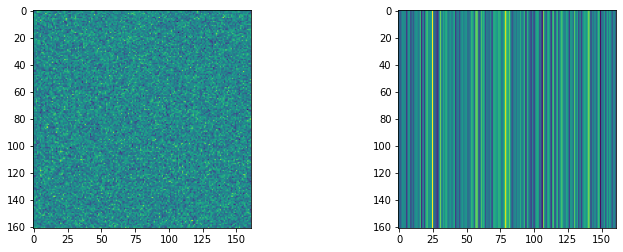

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(data)

plt.subplot(1,2,2)
plt.imshow(start)

In [6]:
test_json = pd.read_json("../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/label_pred.insert.0.0100.json")

In [9]:
test_json.tail()

label                                            predict
96       [24]  [0.0001658184, 0.00021770670000000001, 0.00014...
97       [24]  [0.0001615834, 0.00021756140000000001, 0.00014...
98       [24]  [0.0001535962, 0.00021634640000000002, 0.00014...
99       [24]  [0.0001571397, 0.000214591, 0.0001441630000000...
100  accuracy                                                0.0

In [12]:
'{:<8s} {:>6.4f} {:>8.4f}'.format("insert", 0.01, 97)

'insert   0.0100  97.0000'

In [13]:
with open('test.json', 'r') as f:
    test = json.load(f)

In [15]:
test['test'] = [1,2]

In [16]:
with open('test.json', 'w') as f:
    json.dump(test, f)